# TOPSIS-Based Selection of Pre-trained Conversational Models

In [1]:
!pip install -q transformers datasets evaluate torch accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [2]:
import torch
import time
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
bleu = evaluate.load("bleu")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset = load_dataset(
    "blended_skill_talk",
    split="test[:50]"
)

dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.88M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1009 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/980 [00:00<?, ? examples/s]

Dataset({
    features: ['personas', 'additional_context', 'previous_utterance', 'context', 'free_messages', 'guided_messages', 'suggestions', 'guided_chosen_suggestions', 'label_candidates'],
    num_rows: 50
})

## 2. Models Considered
- DialoGPT
- BlenderBot
- FLAN-T5
- T5
- LLaMA-2-Chat (benchmark-based)

In [6]:
models = {
    "DialoGPT": {
        "name": "microsoft/DialoGPT-small",
        "type": "causal"
    },
    "BlenderBot": {
        "name": "facebook/blenderbot-400M-distill",
        "type": "seq2seq"
    },
    "FLAN-T5": {
        "name": "google/flan-t5-small",
        "type": "seq2seq"
    },
    "T5": {
        "name": "t5-small",
        "type": "seq2seq"
    }
}

In [7]:
def evaluate_model(model_name, model_type):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # FIX 1: GPT-2 / DialoGPT padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # FIX 2: Decoder-only models MUST left-pad
    if model_type == "causal":
        tokenizer.padding_side = "left"

    if model_type == "causal":
        model = AutoModelForCausalLM.from_pretrained(model_name)
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    model.to(device)
    model.eval()

    predictions = []
    references = []

    start_time = time.time()

    for sample in dataset:
        input_text = sample["previous_utterance"]
        reference = sample["free_messages"][0]

        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=50
            )

        prediction = tokenizer.decode(
            outputs[0],
            skip_special_tokens=True
        )

        # FIX 3: BLEU expects STRINGS, not token lists
        predictions.append(prediction)
        references.append(reference)

    end_time = time.time()

    bleu_score = bleu.compute(
        predictions=predictions,
        references=references
    )["bleu"]

    avg_latency = (end_time - start_time) / len(dataset)

    model_size_mb = (
        sum(p.numel() for p in model.parameters()) * 4
    ) / (1024 ** 2)

    return bleu_score, avg_latency, model_size_mb


In [8]:
results = []

for model_name, info in models.items():
    print(f"Evaluating {model_name}...")
    bleu_score, latency, size = evaluate_model(
        info["name"],
        info["type"]
    )
    results.append([model_name, bleu_score, latency, size])

Evaluating DialoGPT...


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/149 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: microsoft/DialoGPT-small
Key                              | Status     |  | 
---------------------------------+------------+--+-
transformer.h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Evaluating BlenderBot...


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/730M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/730M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/355 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Evaluating FLAN-T5...


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/190 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Evaluating T5...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [9]:
results

[['DialoGPT', 0.009075036743592065, 0.14819676876068116, 621.9375],
 ['BlenderBot', 0.0, 0.7418395614624024, 1508.916015625],
 ['FLAN-T5', 0.0, 0.23442896366119384, 293.58349609375],
 ['T5', 0.0, 0.300471396446228, 230.814453125]]

## 3. Evaluation Criteria
- BLEU Score (Benefit)
- Inference Time (Cost)
- Model Size (Cost)
- Human Evaluation Score (Benefit)

In [10]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "BLEU",
        "Inference_Time",
        "Model_Size_MB"
    ]
)

df

,Model,BLEU,Inference_Time,Model_Size_MB
0,DialoGPT,0.009075,0.148197,621.937500
1,BlenderBot,0.000000,0.741840,1508.916016
2,FLAN-T5,0.000000,0.234429,293.583496
3,T5,0.000000,0.300471,230.814453


In [11]:
human_eval = {
    "DialoGPT": 3.6,
    "BlenderBot": 4.1,
    "FLAN-T5": 4.3,
    "T5": 3.9
}

df["Human_Eval"] = df["Model"].map(human_eval)
df

,Model,BLEU,Inference_Time,Model_Size_MB,Human_Eval
0,DialoGPT,0.009075,0.148197,621.937500,3.6
1,BlenderBot,0.000000,0.741840,1508.916016,4.1
2,FLAN-T5,0.000000,0.234429,293.583496,4.3
3,T5,0.000000,0.300471,230.814453,3.9


In [12]:
llama_row = {
    "Model": "LLaMA-2-Chat",
    "BLEU": 0.022,          # reported higher than FLAN-T5
    "Inference_Time": 0.95, # slower due to large size
    "Model_Size_MB": 7000,  # ~7B parameters
    "Human_Eval": 4.5       # reported human preference
}

df = pd.concat([df, pd.DataFrame([llama_row])], ignore_index=True)
df

,Model,BLEU,Inference_Time,Model_Size_MB,Human_Eval
0,DialoGPT,0.009075,0.148197,621.937500,3.6
1,BlenderBot,0.000000,0.741840,1508.916016,4.1
2,FLAN-T5,0.000000,0.234429,293.583496,4.3
3,T5,0.000000,0.300471,230.814453,3.9
4,LLaMA-2-Chat,0.022000,0.950000,7000.000000,4.5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Model           5 non-null      object 
 1   BLEU            5 non-null      float64
 2   Inference_Time  5 non-null      float64
 3   Model_Size_MB   5 non-null      float64
 4   Human_Eval      5 non-null      float64
dtypes: float64(4), object(1)
memory usage: 332.0+ bytes


In [14]:
import numpy as np

weights = np.array([
    0.25,  # BLEU (quality)
    0.25,  # Inference Time (efficiency)
    0.20,  # Model Size (resource usage)
    0.30   # Human Evaluation (usability)
])

In [15]:
impacts = np.array([
    1,   # BLEU → higher is better
   -1,   # Inference Time → lower is better
   -1,   # Model Size → lower is better
    1    # Human Eval → higher is better
])

In [16]:
matrix = df.iloc[:, 1:].values
matrix

array([[9.07503674e-03, 1.48196769e-01, 6.21937500e+02, 3.60000000e+00],
       [0.00000000e+00, 7.41839561e-01, 1.50891602e+03, 4.10000000e+00],
       [0.00000000e+00, 2.34428964e-01, 2.93583496e+02, 4.30000000e+00],
       [0.00000000e+00, 3.00471396e-01, 2.30814453e+02, 3.90000000e+00],
       [2.20000000e-02, 9.50000000e-01, 7.00000000e+03, 4.50000000e+00]])

In [17]:
norm_matrix = matrix / np.sqrt((matrix ** 2).sum(axis=0))
norm_matrix

array([[0.38133224, 0.11643336, 0.08641097, 0.3934485 ],
       [0.        , 0.58283913, 0.2096463 , 0.44809412],
       [0.        , 0.18418318, 0.04079001, 0.46995237],
       [0.        , 0.23607057, 0.03206898, 0.42623587],
       [0.92443806, 0.74638399, 0.97256842, 0.49181062]])

In [18]:
weighted_matrix = norm_matrix[:, :len(weights)] * weights
weighted_matrix

array([[0.09533306, 0.02910834, 0.01728219, 0.11803455],
       [0.        , 0.14570978, 0.04192926, 0.13442824],
       [0.        , 0.0460458 , 0.008158  , 0.14098571],
       [0.        , 0.05901764, 0.0064138 , 0.12787076],
       [0.23110951, 0.186596  , 0.19451368, 0.14754319]])

In [19]:
ideal_best = np.array([
    weighted_matrix[:, i].max() if impacts[i] == 1 else weighted_matrix[:, i].min()
    for i in range(len(impacts))
])

ideal_worst = np.array([
    weighted_matrix[:, i].min() if impacts[i] == 1 else weighted_matrix[:, i].max()
    for i in range(len(impacts))
])

ideal_best, ideal_worst

(array([0.23110951, 0.02910834, 0.0064138 , 0.14754319]),
 array([0.        , 0.186596  , 0.19451368, 0.11803455]))

In [20]:
distance_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

distance_best, distance_worst

(array([0.13937047, 0.26161203, 0.23182866, 0.23386573, 0.24532413]),
 array([0.25554208, 0.15881575, 0.23454116, 0.22749628, 0.23298577]))

In [21]:
df["TOPSIS_Score"] = distance_worst / (distance_best + distance_worst)
df

,Model,BLEU,Inference_Time,Model_Size_MB,Human_Eval,TOPSIS_Score
0,DialoGPT,0.009075,0.148197,621.937500,3.6,0.647085
1,BlenderBot,0.000000,0.741840,1508.916016,4.1,0.377748
2,FLAN-T5,0.000000,0.234429,293.583496,4.3,0.502908
3,T5,0.000000,0.300471,230.814453,3.9,0.493097
4,LLaMA-2-Chat,0.022000,0.950000,7000.000000,4.5,0.487102


In [22]:
df["Rank"] = df["TOPSIS_Score"].rank(method="dense", ascending=False)
df.sort_values("Rank")

,Model,BLEU,Inference_Time,Model_Size_MB,Human_Eval,TOPSIS_Score,Rank
0,DialoGPT,0.009075,0.148197,621.937500,3.6,0.647085,1.0
2,FLAN-T5,0.000000,0.234429,293.583496,4.3,0.502908,2.0
3,T5,0.000000,0.300471,230.814453,3.9,0.493097,3.0
4,LLaMA-2-Chat,0.022000,0.950000,7000.000000,4.5,0.487102,4.0
1,BlenderBot,0.000000,0.741840,1508.916016,4.1,0.377748,5.0


In [23]:
df.sort_values("Rank")

,Model,BLEU,Inference_Time,Model_Size_MB,Human_Eval,TOPSIS_Score,Rank
0,DialoGPT,0.009075,0.148197,621.937500,3.6,0.647085,1.0
2,FLAN-T5,0.000000,0.234429,293.583496,4.3,0.502908,2.0
3,T5,0.000000,0.300471,230.814453,3.9,0.493097,3.0
4,LLaMA-2-Chat,0.022000,0.950000,7000.000000,4.5,0.487102,4.0
1,BlenderBot,0.000000,0.741840,1508.916016,4.1,0.377748,5.0


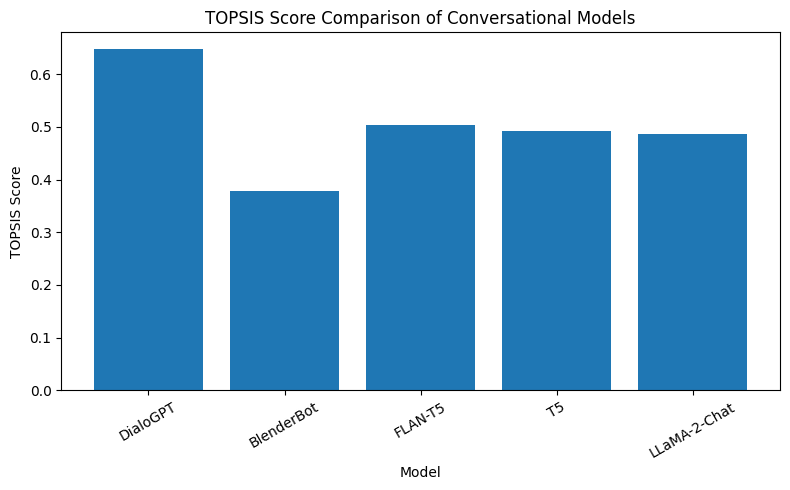

In [24]:
import matplotlib.pyplot as plt

# Bar plot of TOPSIS scores
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["TOPSIS_Score"])
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score Comparison of Conversational Models")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

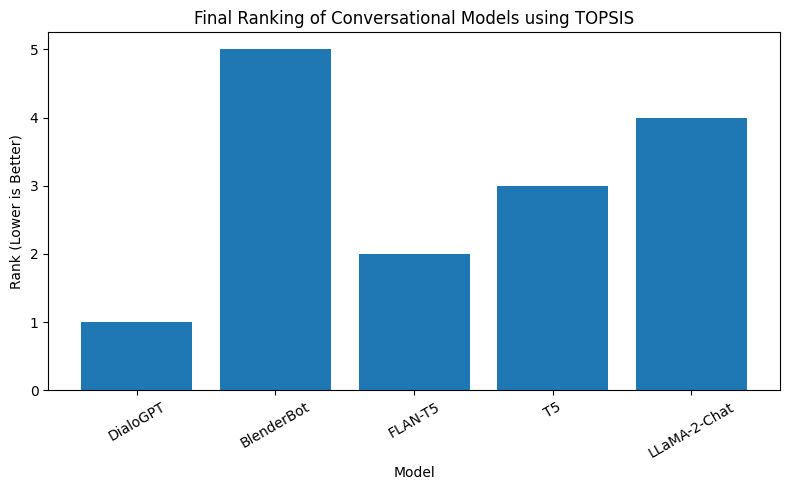

In [25]:
# Rank visualization
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["Rank"])
plt.xlabel("Model")
plt.ylabel("Rank (Lower is Better)")
plt.title("Final Ranking of Conversational Models using TOPSIS")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()